## Metric: post-correction off-ice errors

This method assumes that the off-ice area in the source images has zero horizontal motion. So the ground truth is $V = V_x = V_y = 0$ at the off-ice area. We calculate the difference between the feature tracking results and the ground truth (i.e. zero). 

### Requirements and Limits

- There should be off-ice area in the source images. Works for mountain glaciers and outlet glaciers, but for ice sheet feature tracking it may be hard or impossible to find such the area. 
- Even though there are off-ice areas, this method may still fail if the FT algorithm cannot find cross-correlation over them. One of the possible reasons is the scene pair comes from the melting season as the surface melt changes the surface texture a lot. There are ways to check this up in this Notebook.

### Procedure

1. Prepare the feature tracking results as Geotiff files, ideally $V_x$ as one file and $V_y$ as the other. (We also show the case if only $V$ is available.) The unit for pixel value is flexible, from pixels, pixels/day, pixels/year, to meters, meters/day, to meters/year.

2. Locate off-ice area and make an ESRI shapefile (polygon format) indicating the area.

3. Use `gftt.off_ice_errors` to calculate and analyze the off-ice errors. See this notebook for details.

### Analysis

#### 1. Information and map area

- Test area: Kaskawulsh
- Test package: CARST and GIV
- Test pair: 20180304-20180405

In [1]:
# Developer's setting
%load_ext autoreload
%autoreload 2

In [150]:
import gftt
import matplotlib.pyplot as plt
from matplotlib import colors, cm
from matplotlib.colors import ListedColormap
import rasterio
from rasterio.plot import show
import numpy as np
import pandas as pd
import geopandas as gpd
import glob

#### 2. Prepare metadata as a Pandas dataframe, and load off-ice area info

In [72]:
carst_vxs = sorted(glob.glob('/home/jovyan/Projects/PX_comparison/PX/CARST/*/*velo-raw_vx.tif'))
carst_vys = sorted(glob.glob('/home/jovyan/Projects/PX_comparison/PX/CARST/*/*velo-raw_vy.tif'))

df = pd.DataFrame(columns = ['Date', 'Chip (px)', 'Resolution (px)', 'Prefilter', 'Subpixel', 'Software', 'Vx', 'Vy'])

for i, j in zip(carst_vxs, carst_vys):
    info = i.split('/')[-2]
    date_raw =  info.split('_')[1]
    chip =      info.split('_')[3][-2:]
    res =       info.split('_')[4][4:]
    prefilter = info.split('_')[5]
    subpixel = '16-node oversampling'
    if date_raw == '20180314':
        date = 'Sen2-20180304-20180314'
    elif date_raw == '20180405':
        date = 'LS8-20180304-20180405'
    elif date_raw == '20180627':
        date = 'Sen2-20180508-20180627'
    elif date_raw == '20180818':
        date = 'LS8-20180802-20180818'
    else:
        raise ValueError('Strange date string!')
    row = {'Date':      date,      'Chip (px)': chip,     'Resolution (px)': res,
           'Prefilter': prefilter, 'Subpixel':  subpixel, 'Software':        'CARST',
           'Vx': i,                'Vy': j}
    df = df.append(row, ignore_index=True)
    
giv_vxs = sorted(glob.glob('/home/jovyan/Projects/PX_comparison/PX/GIV/u*.tif'))
giv_vys = sorted(glob.glob('/home/jovyan/Projects/PX_comparison/PX/GIV/v*.tif'))

for i, j in zip(giv_vxs, giv_vys):
    info = i.split('/')[-1]
    date_raw =  info.split('_')[1]
    chip =      'multi'
    res_raw =   info.split('_')[3][:-4]
    prefilter_raw = info.split('_')[2]
    subpixel = 'interest point groups'
    if date_raw == 's12':
        date = 'Sen2-20180304-20180314'
    elif date_raw == 'l12':
        date = 'LS8-20180304-20180405'
    elif date_raw == 's34':
        date = 'Sen2-20180508-20180627'
    elif date_raw == 'l34':
        date = 'LS8-20180802-20180818'
    else:
        raise ValueError('Strange date string!')
    if res_raw == '50':
        if date_raw == 's12' or date_raw == 's34':
            res = '5'    # 50 m posting (acutal number is 54-40 m)
        elif date_raw == 'l12' or date_raw == 'l34':
            res = '4'    # 60 m posting
        else:
            raise ValueError('Something wrong! #1')
    elif res_raw == '200':
        if date_raw == 's12' or date_raw == 's34':
            res = '20'   # 200 m posting (actual number is 219-160 m)
        elif date_raw == 'l12' or date_raw == 'l34':
            res = '16'   # 240 m posting
        else:
            raise ValueError('Something wrong! #1')
    else:
        raise ValueError('Strange resolution!')
    if prefilter_raw == 'gaus':
        prefilter = 'Gau'
    elif prefilter_raw == 'NAOF':
        prefilter = 'NAOF'
    elif prefilter_raw == 'r':
        prefilter = 'None'
    else:
        raise ValueError('Strange prefilter!')
    row = {'Date':      date,      'Chip (px)': chip,     'Resolution (px)': res,
           'Prefilter': prefilter, 'Subpixel':  subpixel, 'Software':        'GIV',
           'Vx': i,                'Vy': j}
    df = df.append(row, ignore_index=True)

In [73]:
df

,Date,Chip (px),Resolution (px),Prefilter,Subpixel,Software,Vx,Vy
0,Sen2-20180304-20180314,48,12,Gau,16-node oversampling,CARST,/home/jovyan/Projects/PX_comparison/PX/CARST/2...,/home/jovyan/Projects/PX_comparison/PX/CARST/2...
1,Sen2-20180304-20180314,48,12,NAOF,16-node oversampling,CARST,/home/jovyan/Projects/PX_comparison/PX/CARST/2...,/home/jovyan/Projects/PX_comparison/PX/CARST/2...
2,Sen2-20180304-20180314,48,12,None,16-node oversampling,CARST,/home/jovyan/Projects/PX_comparison/PX/CARST/2...,/home/jovyan/Projects/PX_comparison/PX/CARST/2...
3,Sen2-20180304-20180314,48,1,Gau,16-node oversampling,CARST,/home/jovyan/Projects/PX_comparison/PX/CARST/2...,/home/jovyan/Projects/PX_comparison/PX/CARST/2...
4,Sen2-20180304-20180314,48,1,NAOF,16-node oversampling,CARST,/home/jovyan/Projects/PX_comparison/PX/CARST/2...,/home/jovyan/Projects/PX_comparison/PX/CARST/2...
...,...,...,...,...,...,...,...,...
91,Sen2-20180508-20180627,multi,5,NAOF,interest point groups,GIV,/home/jovyan/Projects/PX_comparison/PX/GIV/u_s...,/home/jovyan/Projects/PX_comparison/PX/GIV/v_s...
92,Sen2-20180508-20180627,multi,20,Gau,interest point groups,GIV,/home/jovyan/Projects/PX_comparison/PX/GIV/u_s...,/home/jovyan/Projects/PX_comparison/PX/GIV/v_s...
93,Sen2-20180508-20180627,multi,5,Gau,interest point groups,GIV,/home/jovyan/Projects/PX_comparison/PX/GIV/u_s...,/home/jovyan/Projects/PX_comparison/PX/GIV/v_s...
94,Sen2-20180508-20180627,multi,20,None,interest point groups,GIV,/home/jovyan/Projects/PX_comparison/PX/GIV/u_s...,/home/jovyan/Projects/PX_comparison/PX/GIV/v_s...


In [93]:
# off-ice area
in_shp = '../../data/shapefiles/bedrock_V1.shp'
off_ice = gpd.read_file(in_shp)

#### 3. Single-pair demo 

In [172]:
## Example results
demo = df.loc[30]
print(demo)

Date                                           LS8-20180304-20180405
Chip (px)                                                         64
Resolution (px)                                                    4
Prefilter                                                        Gau
Subpixel                                        16-node oversampling
Software                                                       CARST
Vx                 /home/jovyan/Projects/PX_comparison/PX/CARST/2...
Vy                 /home/jovyan/Projects/PX_comparison/PX/CARST/2...
Name: 30, dtype: object


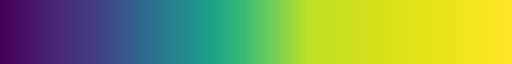

In [183]:
viridis = cm.get_cmap('viridis', 256)
newcolors1 = viridis(np.linspace(0, 0.2, 128))
newcolors2 = viridis(np.linspace(0.2, 0.9, 256))
newcolors3 = viridis(np.linspace(0.9, 1, 256))
newcolors = np.vstack((newcolors1, newcolors2, newcolors3))
cmap = ListedColormap(newcolors)
cmap.set_over(np.array([202,0,32,128]) / 255)
cmap.set_under(np.array([0,0,0,128]) / 255)
cmap

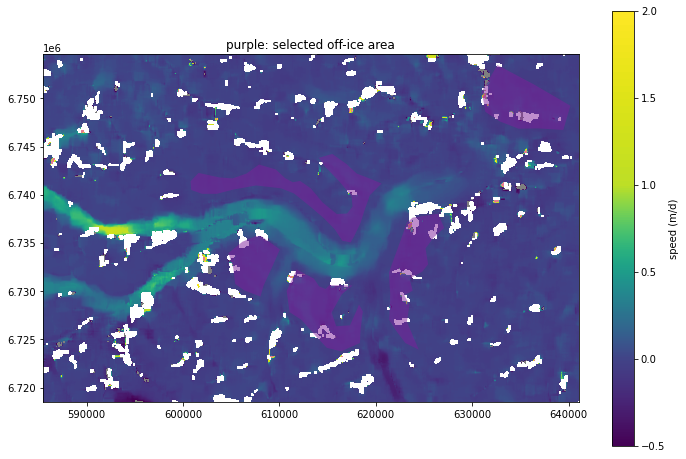

In [185]:
fig, ax0 = plt.subplots(1, 1, figsize=(12, 8))

# with rasterio.open(demo.Vx.replace('vx', 'mag')) as v_src:
#     v = v_src.read(1)
#     show(v_src, ax=ax0, vmin=0, vmax=2, cmap=cmap)

with rasterio.open(demo.Vx) as v_src:
    v = v_src.read(1)
    show(v_src, ax=ax0, vmin=-0.5, vmax=2, cmap=cmap)
    
cbar =  fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin=-0.5, vmax=2), cmap=cmap), ax=ax0)
cbar.set_label('speed (m/d)')
off_ice.plot(ax=ax0, alpha=0.5, facecolor='xkcd:purple')
ax0.set_title('purple: selected off-ice area');

The GFTT module has a fuction called `off_ice_errors` for this metric:

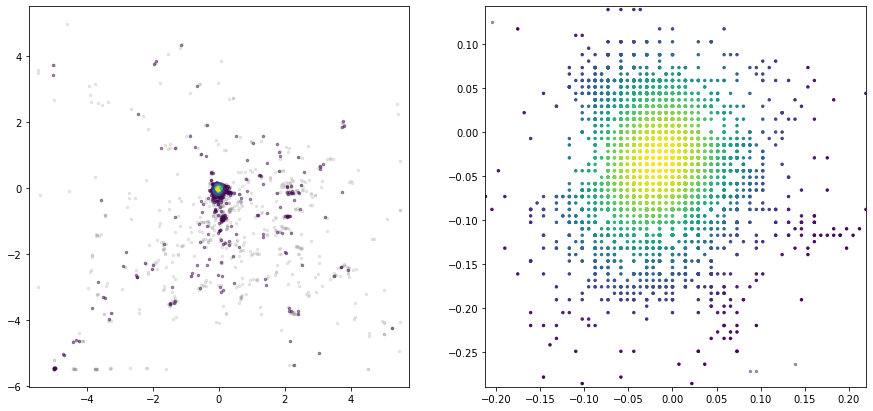

In [186]:
fig, ax1 = plt.subplots(1, 2, figsize=(15, 7))

for ax in ax1:
    ax.axis('equal')
vx, vy, z, thres_idx = gftt.off_ice_errors(vxfile=demo.Vx, vyfile=demo.Vy, off_ice_area=in_shp, ax=ax1[0])
gftt.plot_off_ice_errors(vx, vy, z, thres_idx, ax=ax1[1])


In this case, x-axis is $V_x$ (m/day), y-axis is $V_y$ (m/day), color represents the Gaussian kernel density estimate, and transparent points indicate that those points have a kernel density below a chosen confidence level. The default `thres_sigma` parameter is 3.0, corresponding to a confidence level of 99.7%. 

To estimate whether these errors are randomly distributed, we can see how close this distribution is to the Gaussian distribution. One criterion is to see how much the non-transparent points account for 99.7% of all the points and whether that is close to 99.7%:

In [187]:
np.sum(thres_idx) / vx.shape

array([0.9743])

This gives us 94.5%, indicating more points falling outside of the chosen confidence interval than assumed. This is okay because the standard deviation of these points would be a conservative estimate, affected by many outliers and larger than the actual standard deviation. 

The standard deviation of $V_x$ and $V_y$ can be thus assigned as the overall uncertainty of both on-ice and off-ice pixels, which serves as a metric for estimating the feature tracking results. 

In [188]:
print('Vx std: {:5f}  m/day'.format(np.std(vx, ddof=1)))
print('Vy std: {:5f}  m/day'.format(np.std(vy, ddof=1)))

Vx std: 0.317885  m/day
Vy std: 0.337297  m/day


Or roughly 1/5 of the pixel size since this is a 32-day pair.

<!-- ![CARST-bedrock](./20180304-20180405_bedrock_vx-vs-vy.png) -->

In [189]:
print('Vx std: {:5f}  m/day'.format(np.std(vx[thres_idx], ddof=1)))
print('Vy std: {:5f}  m/day'.format(np.std(vy[thres_idx], ddof=1)))

Vx std: 0.040749  m/day
Vy std: 0.052307  m/day


#### 3.1 image with many off-ice pixels

In [161]:
# CARST files (Vx and Vy)
carst_geotiff_x = '/home/jovyan/Projects/PX_comparison/PX/CARST/20180304_20180405_LS8-061018_chip32_skip1_Gau/20180304-20180405_velo-raw_vx.tif'
carst_geotiff_y = '/home/jovyan/Projects/PX_comparison/PX/CARST/20180304_20180405_LS8-061018_chip32_skip1_Gau/20180304-20180405_velo-raw_vy.tif'

**old code (using all 721549 samples)**

This would take 2 hours to run. Not very effective because for many areas the KDE is just very low.

In [162]:
# %%time
# vx, vy, z, thres_idx = gftt.off_ice_errors(vxfile=carst_geotiff_x, vyfile=carst_geotiff_y, off_ice_area=in_shp)
# max_n = 721549

In [163]:
#### These numbers are very similar from only using n=10000 points.
# print(np.sum(thres_idx) / vx.shape)
# print('Vx std: {:5f}  m/day'.format(np.std(vx, ddof=1)))
# print('Vy std: {:5f}  m/day'.format(np.std(vy, ddof=1)))

**New code (using 10000 samples)**

CPU times: user 1.54 s, sys: 23.9 ms, total: 1.56 s
Wall time: 1.6 s


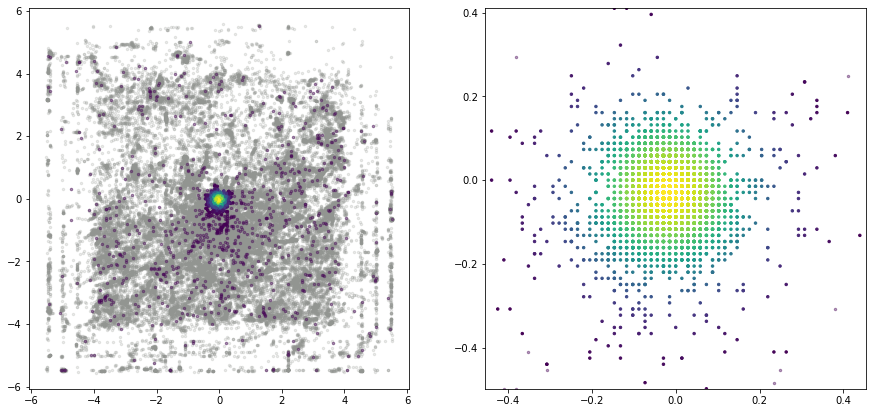

In [164]:
%%time
fig, ax2 = plt.subplots(1, 2, figsize=(15, 7))

for ax in ax2:
    ax.axis('equal')
vx, vy, z, thres_idx = gftt.off_ice_errors(vxfile=carst_geotiff_x, vyfile=carst_geotiff_y, off_ice_area=in_shp, max_n=10000, ax=ax2[0])
gftt.plot_off_ice_errors(vx, vy, z, thres_idx, ax=ax2[1])

In [165]:
print(np.sum(thres_idx) / vx.shape)
print('Vx std: {:5f}  m/day'.format(np.std(vx, ddof=1)))
print('Vy std: {:5f}  m/day'.format(np.std(vy, ddof=1)))

[0.9133]
Vx std: 0.693019  m/day
Vy std: 0.671267  m/day


In [166]:
print('Vx std: {:5f}  m/day'.format(np.std(vx[thres_idx], ddof=1)))
print('Vy std: {:5f}  m/day'.format(np.std(vy[thres_idx], ddof=1)))

Vx std: 0.063391  m/day
Vy std: 0.069583  m/day


#### 4. Many tests

In [216]:
## Example results
# demo = df.loc[df['Date'] == 'LS8-20180304-20180405']
# demo = df.loc[df['Date'] == 'LS8-20180802-20180818']
# demo = df.loc[df['Date'] == 'Sen2-20180304-20180314']
demo = df.loc[df['Date'] == 'Sen2-20180508-20180627']
# There are 24 tests
demo

,Date,Chip (px),Resolution (px),Prefilter,Subpixel,Software,Vx,Vy
36,Sen2-20180508-20180627,48,12,Gau,16-node oversampling,CARST,/home/jovyan/Projects/PX_comparison/PX/CARST/2...,/home/jovyan/Projects/PX_comparison/PX/CARST/2...
37,Sen2-20180508-20180627,48,12,NAOF,16-node oversampling,CARST,/home/jovyan/Projects/PX_comparison/PX/CARST/2...,/home/jovyan/Projects/PX_comparison/PX/CARST/2...
38,Sen2-20180508-20180627,48,12,None,16-node oversampling,CARST,/home/jovyan/Projects/PX_comparison/PX/CARST/2...,/home/jovyan/Projects/PX_comparison/PX/CARST/2...
39,Sen2-20180508-20180627,48,1,Gau,16-node oversampling,CARST,/home/jovyan/Projects/PX_comparison/PX/CARST/2...,/home/jovyan/Projects/PX_comparison/PX/CARST/2...
40,Sen2-20180508-20180627,48,1,NAOF,16-node oversampling,CARST,/home/jovyan/Projects/PX_comparison/PX/CARST/2...,/home/jovyan/Projects/PX_comparison/PX/CARST/2...
41,Sen2-20180508-20180627,48,1,None,16-node oversampling,CARST,/home/jovyan/Projects/PX_comparison/PX/CARST/2...,/home/jovyan/Projects/PX_comparison/PX/CARST/2...
42,Sen2-20180508-20180627,48,4,Gau,16-node oversampling,CARST,/home/jovyan/Projects/PX_comparison/PX/CARST/2...,/home/jovyan/Projects/PX_comparison/PX/CARST/2...
43,Sen2-20180508-20180627,48,4,NAOF,16-node oversampling,CARST,/home/jovyan/Projects/PX_comparison/PX/CARST/2...,/home/jovyan/Projects/PX_comparison/PX/CARST/2...
44,Sen2-20180508-20180627,48,4,None,16-node oversampling,CARST,/home/jovyan/Projects/PX_comparison/PX/CARST/2...,/home/jovyan/Projects/PX_comparison/PX/CARST/2...
45,Sen2-20180508-20180627,64,12,Gau,16-node oversampling,CARST,/home/jovyan/Projects/PX_comparison/PX/CARST/2...,/home/jovyan/Projects/PX_comparison/PX/CARST/2...


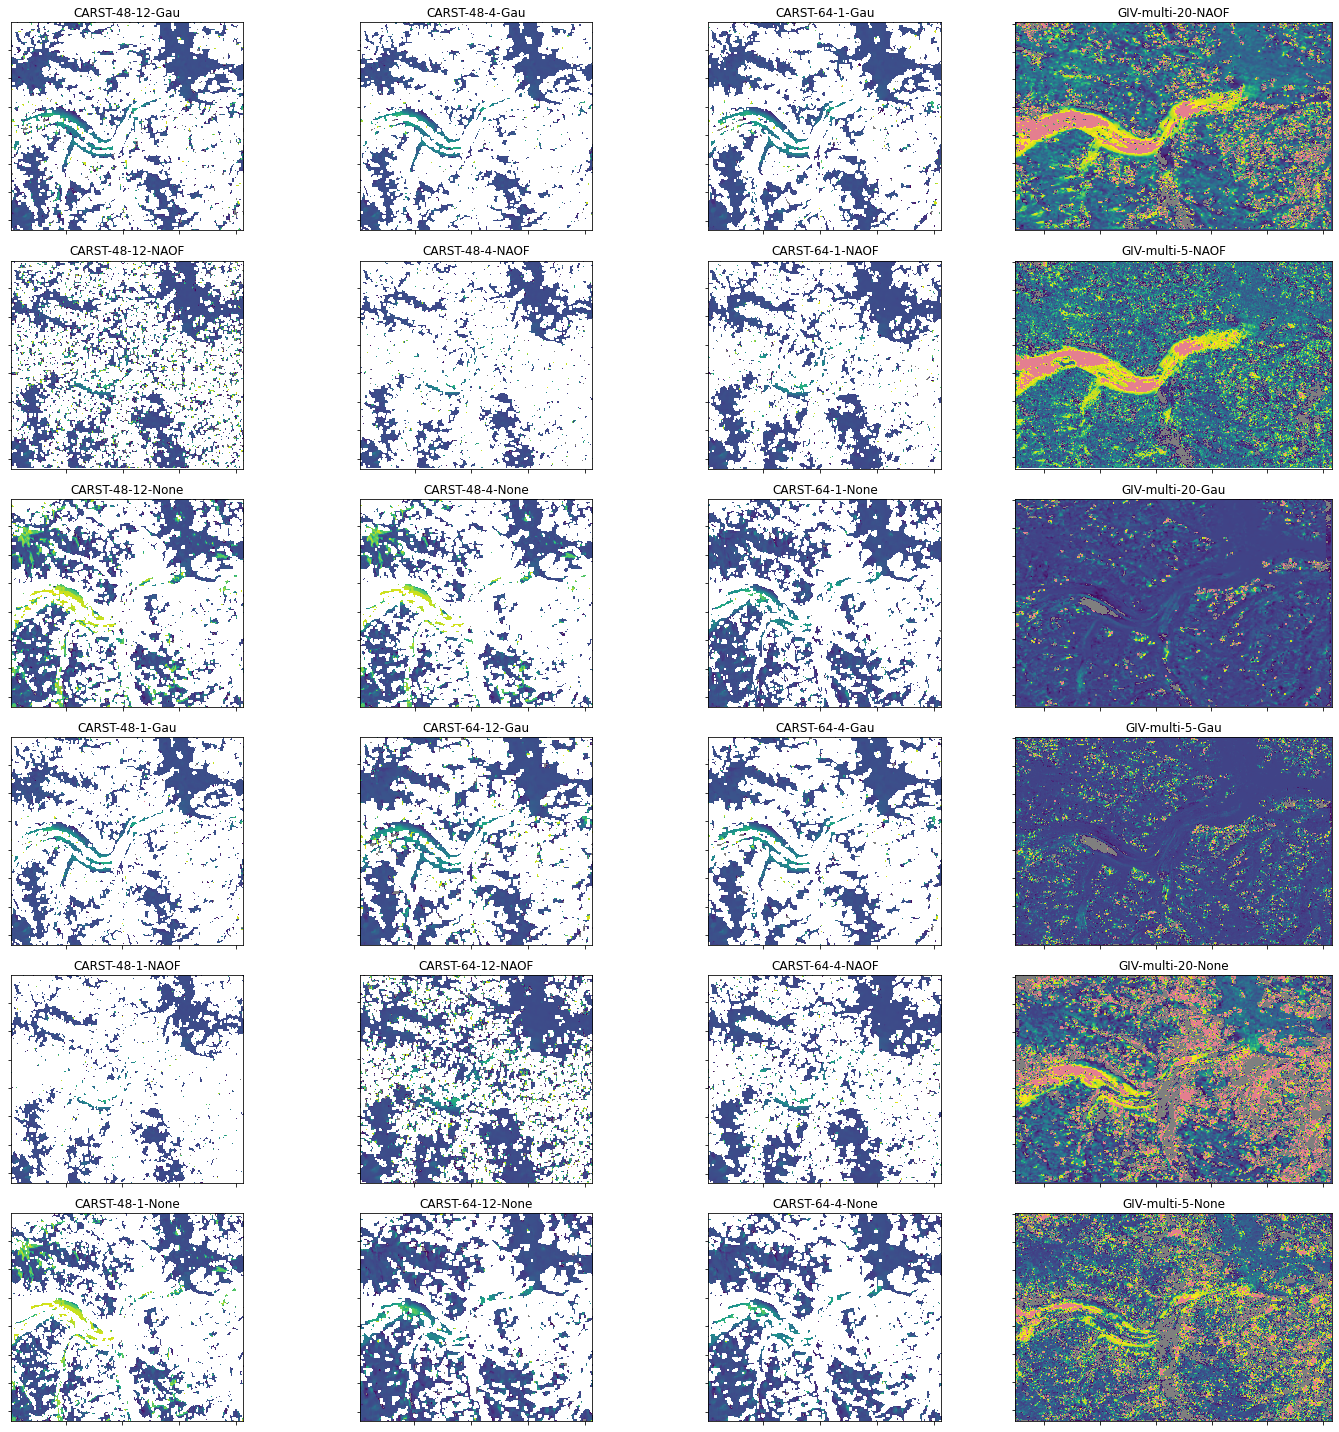

In [217]:
fig, ax3 = plt.subplots(6, 4, figsize=(20, 20))

n = 0

for idx, row in demo.iterrows():
    label = '-'.join((row.Software, row['Chip (px)'], row['Resolution (px)'], row.Prefilter))
    ax_sel = ax3[n % 6, n // 6]
    
    with rasterio.open(row.Vx) as vx_src:
        show(vx_src, ax=ax_sel, vmin=-0.5, vmax=2, cmap=cmap)
    ax_sel.set_title(label)
    ax_sel.xaxis.set_ticklabels([])
    ax_sel.yaxis.set_ticklabels([])
        
    n += 1
    
plt.tight_layout()
# cbar =  fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin=-0.5, vmax=2), cmap=cmap), ax=ax0)
# cbar.set_label('speed (m/d)')
# off_ice.plot(ax=ax0, alpha=0.5, facecolor='xkcd:purple')
# ax0.set_title('purple: selected off-ice area');
# fig.savefig('tmp.png')